## Just in case I need this
income_data = pd.read_excel("data/household_income.xlsx", skiprows = 1, header=[0, 1], sheet_name = 0)
income_data = income_data[income_data.columns.drop(list(income_data.filter(regex='Error')))]
income_data.columns = income_data.columns.droplevel(1)
income_clean = income_data.set_index('Unnamed: 0_level_0').T.reset_index().rename({"index": "zipcode"}, axis = 1)

In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

import fnmatch

In [2]:
vaccines = pd.read_csv('../data/vaccine_with_protocol.csv')
covid = pd.read_csv('../data/COVID_CountByZipPerDate 03292021.csv')
pop = pd.read_csv('../data/pop_by_zip.csv')
edu = pd.read_csv('../data/education_by_zip.csv')

In [3]:
##only looking at first dose of vaccines
vaccines = vaccines[vaccines.dose_nbr == 1.0]

In [4]:
pd.value_counts(vaccines['protocol'])

two-shot    3237
one-shot     730
Name: protocol, dtype: int64

In [5]:
###how many dates of vaccinations there have been
vacc_occurences = pd.value_counts(vaccines['zipcode'])
vacc_occurences = vacc_occurences.reset_index()

In [6]:
###How many dates of positive tests have there been 
covid_dates = pd.value_counts(covid['Zip'])
covid_dates = covid_dates.reset_index()

In [7]:
vac_per_zip = vaccines.groupby('zipcode')['count_given'].sum()
vac_per_zip = vac_per_zip.reset_index()

In [8]:
low_vac = vac_per_zip[vac_per_zip['count_given'] <= 5000]

In [9]:
low_vac

,zipcode,count_given
1,37027.0,352.0
2,37069.0,50.0
5,37080.0,1970.0
8,37189.0,1056.0
9,37201.0,576.0
17,37210.0,3747.0
20,37213.0,72.0
25,37218.0,4391.0
26,37219.0,638.0
27,37220.0,3239.0


<AxesSubplot:xlabel='zipcode'>

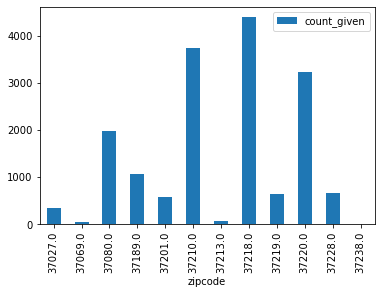

In [10]:
low_vac.plot.bar('zipcode', 'count_given')

In [11]:
high_vac = vac_per_zip[vac_per_zip['count_given'] >= 15000]

<AxesSubplot:xlabel='zipcode'>

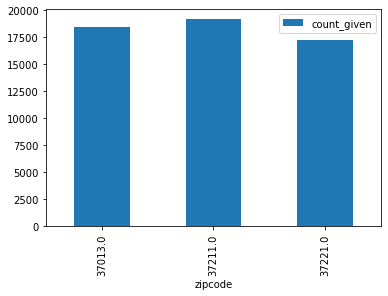

In [12]:
high_vac.plot.bar('zipcode', 'count_given')

Text(0, 0.5, 'Price')

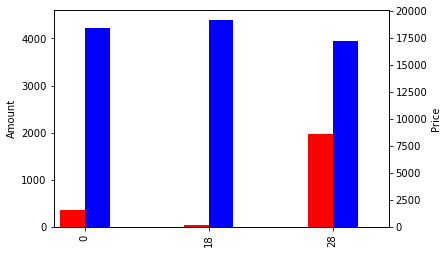

In [13]:
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = .2

low_vac.count_given.plot(kind='bar', color='red', ax=ax, width=width, position=1)
high_vac.count_given.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Amount')
ax2.set_ylabel('Price')

In [14]:
covid_dates

,index,Zip
0,37013.0,382
1,37211.0,379
2,37209.0,364
3,37217.0,362
4,37207.0,361
5,37115.0,361
6,37076.0,357
7,37214.0,355
8,37203.0,344
9,37221.0,342


In [15]:
covid_per_zip = covid.groupby('Zip')['Cases'].sum()
covid_per_zip = covid_per_zip.reset_index()

Text(0, 0.5, 'Price')

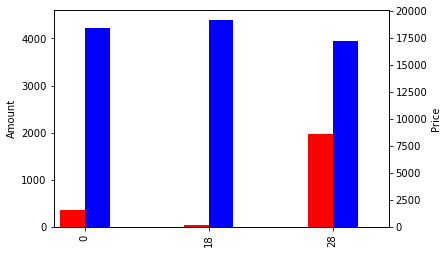

In [16]:
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = .2

low_vac.count_given.plot(kind='bar', color='red', ax=ax, width=width, position=1)
high_vac.count_given.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Amount')
ax2.set_ylabel('Price')

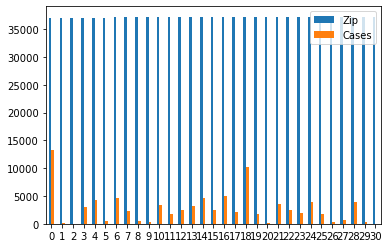

In [17]:
covid_per_zip.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
plt.show()

In [18]:
covid_per_zip = covid_per_zip.rename(columns = {'Zip':'zipcode', 'Cases': 'tot_cases'})

In [19]:
zip_stats = pd.merge(covid_per_zip, vac_per_zip, on = 'zipcode')

<AxesSubplot:xlabel='zipcode'>

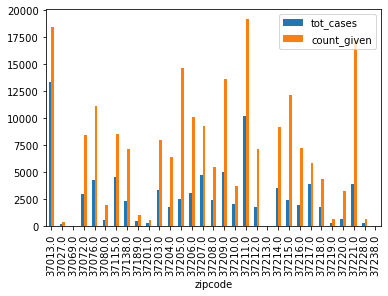

In [20]:
zip_stats.plot(x="zipcode", y=["tot_cases", "count_given"], kind="bar")

### Playing with Education information

In [21]:
###renaming columns to organize better
edu = edu.rename(columns ={'Unnamed: 0': 'zip'}) 

In [22]:
edu

,zip,total,none,perc_none,n_4,perc_n_4,n_4_orless,perc_n_4_orless,5_6,perc_5_6,...,master_orless,perc_master_orless,professional,perc_professional,professional_orless,perc_professional_orless,doctorate,perc_doctorate,doctorate_orless,perc_doctorate_orless
0,37010,3247.0,0.0,0.00,0.0,0.00,0.0,0.00,1.0,0.03,...,3181.0,97.97,47.0,1.45,3228.0,99.41,19.0,0.59,3247.0,100.0
1,37012,1675.0,11.0,0.66,2.0,0.12,13.0,0.78,0.0,0.00,...,1671.0,99.76,0.0,0.00,1671.0,99.76,4.0,0.24,1675.0,100.0
2,37013,62355.0,1822.0,2.92,355.0,0.57,2177.0,3.49,951.0,1.53,...,60991.0,97.81,1055.0,1.69,62046.0,99.50,309.0,0.50,62355.0,100.0
3,37014,2012.0,9.0,0.45,0.0,0.00,9.0,0.45,0.0,0.00,...,1916.0,95.23,42.0,2.09,1958.0,97.32,54.0,2.68,2012.0,100.0
4,37015,12590.0,79.0,0.63,31.0,0.25,110.0,0.87,78.0,0.62,...,12370.0,98.25,104.0,0.83,12474.0,99.08,116.0,0.92,12590.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,38552,131.0,4.0,3.05,0.0,0.00,4.0,3.05,0.0,0.00,...,131.0,100.00,0.0,0.00,131.0,100.00,0.0,0.00,131.0,100.0
111,38560,1042.0,13.0,1.25,0.0,0.00,13.0,1.25,14.0,1.34,...,1038.0,99.62,4.0,0.38,1042.0,100.00,0.0,0.00,1042.0,100.0
112,38563,2195.0,13.0,0.59,0.0,0.00,13.0,0.59,0.0,0.00,...,2195.0,100.00,0.0,0.00,2195.0,100.00,0.0,0.00,2195.0,100.0
113,38567,536.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,526.0,98.13,10.0,1.87,536.0,100.00,0.0,0.00,536.0,100.0


In [23]:
edu = edu[['zip', 'total', 'perc_none', 'perc_12_orless','perc_hs_grad', 'perc_col_<1', 'perc_col_>1','perc_associate', 'perc_bachelor','perc_master', 'perc_professional','perc_doctorate']]

In [24]:
edu['somecollege'] = edu['perc_col_<1'] + edu['perc_col_>1']
edu['highered'] = edu['perc_master'] + edu['perc_professional'] + edu['perc_doctorate']
edu = edu[['zip', 'total', 'perc_12_orless','perc_hs_grad','perc_associate', 'perc_bachelor','perc_master', 'perc_professional','perc_doctorate', 'somecollege', 'highered']]

<ipython-input-24-1f4f1a471253>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edu['somecollege'] = edu['perc_col_<1'] + edu['perc_col_>1']
<ipython-input-24-1f4f1a471253>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edu['highered'] = edu['perc_master'] + edu['perc_professional'] + edu['perc_doctorate']


In [25]:
###Converting to a string to filter 
edu['zip'] = edu['zip'].astype(str)

In [26]:
edu['college_eded'] = edu['somecollege'] + edu['highered']

In [27]:
edu

,zip,total,perc_12_orless,perc_hs_grad,perc_associate,perc_bachelor,perc_master,perc_professional,perc_doctorate,somecollege,highered,college_eded
0,37010,3247.0,8.16,25.22,7.33,16.72,12.01,1.45,0.59,28.52,14.05,42.57
1,37012,1675.0,17.19,47.10,6.81,8.60,0.90,0.00,0.24,19.17,1.14,20.31
2,37013,62355.0,12.14,25.61,9.06,22.97,7.79,1.69,0.50,20.23,9.98,30.21
3,37014,2012.0,8.30,18.09,5.07,34.99,13.57,2.09,2.68,15.21,18.34,33.55
4,37015,12590.0,15.81,40.36,6.25,11.82,3.81,0.83,0.92,20.20,5.56,25.76
...,...,...,...,...,...,...,...,...,...,...,...,...
110,38552,131.0,9.92,66.41,3.05,17.56,0.00,0.00,0.00,3.05,0.00,3.05
111,38560,1042.0,23.90,43.95,4.41,10.94,2.11,0.38,0.00,14.30,2.49,16.79
112,38563,2195.0,17.72,44.60,3.37,7.47,8.20,0.00,0.00,18.63,8.20,26.83
113,38567,536.0,1.31,49.44,12.50,22.39,3.54,1.87,0.00,8.96,5.41,14.37


## Back to Mapping

In [28]:
###prepping pop(population stats) for merging and stuff
pop = pop.rename(columns = {'Zip':'zip'})
pop['zip'] = pop['zip'].astype(str)

In [29]:
## Dropping 'location'
pop = pop.drop(columns = 'Location')

In [30]:
###prepping data for heatmap - changing names to match geojson file
zip_stats = zip_stats.rename(columns = {'zipcode':'zip', 'count_given': 'vacc_count'})

In [31]:
###Converting 'zip' to string to make it legible for GeoJson file
zip_stats['zip'] = zip_stats['zip'].astype(int)
zip_stats['zip'] = zip_stats['zip'].astype(str)

In [32]:
##Appending population stuff to zip stats
zip_stats = pd.merge(zip_stats, pop, on = 'zip')

In [33]:
###Adding a column for vaccination density
zip_stats['vacc_density'] = zip_stats['vacc_count'] / zip_stats['Population']
zip_stats['covid_density'] = zip_stats['tot_cases'] / zip_stats['Population']
zip_stats['vacc_density'] = zip_stats['vacc_density'] * 100

## Playing with Geospatial stuff

In [34]:
###Checking Individuals Ones
vaccines.loc[vaccines['zipcode'] == 37027.0, 'count_given'].sum()

352.0

In [35]:
###Playing with GeoSpatial Info
zipcodes = gpd.read_file('../data/zipcodes.geojson')

In [36]:
stat_map = pd.merge(zipcodes, zip_stats, on = 'zip')

<AxesSubplot:>

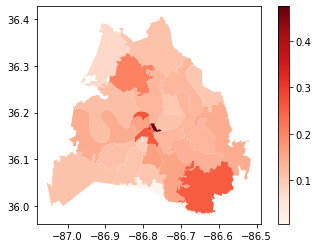

In [37]:
###vaccines by amount
stat_map.plot(column = 'covid_density', cmap = 'Reds', legend = True)

<AxesSubplot:>

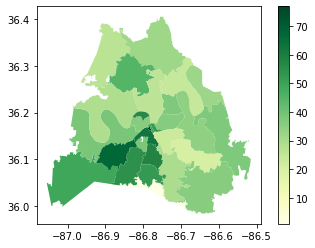

In [38]:
stat_map.plot(column = 'vacc_density', cmap = 'YlGn', legend = True)

### Merging Map info to education info

In [39]:
edu_merge = pd.merge(zip_stats, edu, on = 'zip')

In [40]:
###redefining stuff for maps
edu_map = pd.merge(zipcodes, edu_merge, on = 'zip')

<AxesSubplot:>

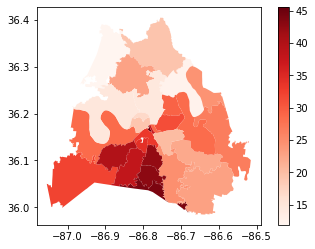

In [41]:
edu_map.plot(column = 'perc_bachelor', cmap = 'Reds', legend = True)

In [42]:
test_map = edu_map

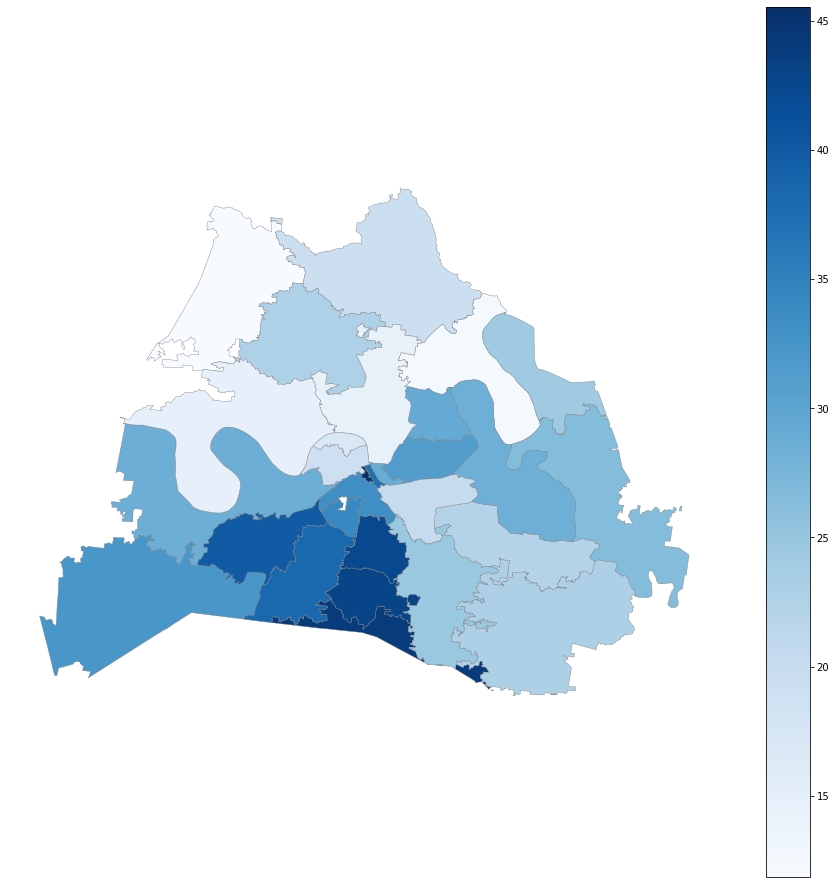

In [43]:
fig, ax = plt.subplots(figsize=(16,16))
edu_map.plot(ax=ax, column="perc_bachelor", cmap="Blues",edgecolor="grey", linewidth=0.4, legend=True)
ax.axis("off")
plt.axis('equal')
plt.show()

In [44]:
test_map['vacc_density'] =  test_map['vacc_density']* 10

In [45]:
test_map = test_map.to_crs(3857)

In [46]:
test_points = test_map.copy()
test_points['geometry'] = test_map['geometry'].centroid

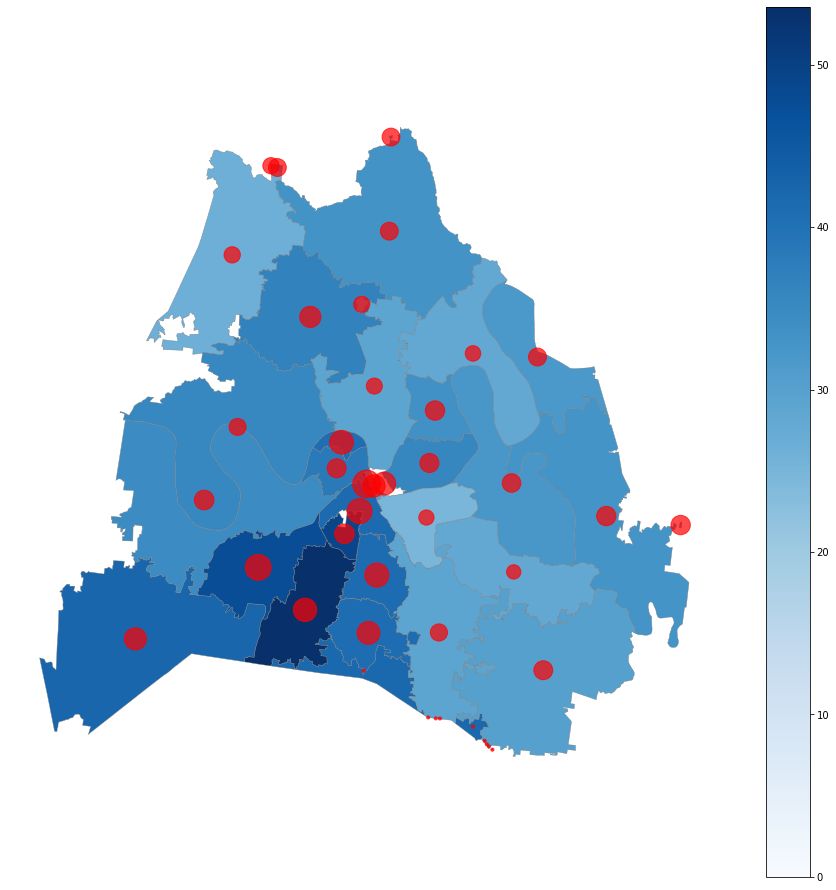

In [54]:
fig, ax = plt.subplots(figsize=(16,16))
test_map.plot(ax=ax, column="college_eded", cmap="Blues", edgecolor="grey", legend = True, linewidth=0.4)
test_points.plot(ax=ax,color ="red", markersize = "vacc_density", alpha=.7, categorical= True, legend = True)

ax.axis("off")
plt.axis('equal')
plt.show()

In [48]:
###Save Map
##plt.savefig('vac_by_zip_map.png')

In [49]:
test_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   zip                42 non-null     object  
 1   objectid           42 non-null     object  
 2   po_name            42 non-null     object  
 3   shape_stlength     42 non-null     object  
 4   shape_starea       42 non-null     object  
 5   geometry           42 non-null     geometry
 6   tot_cases          42 non-null     int64   
 7   vacc_count         42 non-null     float64 
 8   Population         42 non-null     int64   
 9   Den                21 non-null     float64 
 10  vacc_density       42 non-null     float64 
 11  covid_density      42 non-null     float64 
 12  total              42 non-null     float64 
 13  perc_12_orless     42 non-null     float64 
 14  perc_hs_grad       42 non-null     float64 
 15  perc_associate     42 non-null     float64 
 16  pe

random code
givenvax_top5 = sns.catplot(x="zipcode", y="total_vaccines_given", kind="bar", data=vax_5, order=vax_5.sort_values('total_vaccines_given').zipcode)

From Ryan Hilber to Everyone:  11:27 AM
plt.savefig('vac_by_zip_map.png')

From Ryan Hilber to Everyone:  11:34 AM
x = df_all_2['perc_associate_ormore']
y = df_all_2['vac_by_perc']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")
From Carlos Miranda Pereyra to Everyone:  12:37 PM
Secondary or less vs. post-secondary and more
From Teng Ye to Everyone:  12:54 PM
plt.savefig('../assets/covid_weather.png')

From Teresa Whitesell to Everyone:  12:56 PM
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html

From Ian gray to Everyone:  01:03 PM
that makes perfect sense and I agree

From Joshua Rio-Ross to Everyone:  01:36 PM
df.corr()

From Rachel Hertel to Everyone:  01:36 PM
z = np.polyfit(age_pos_vacc['21 to 39'], age_pos_vacc['%vaxxed'], 1)
p = np.poly1d(z)
ax.plot(age_pos_vacc['21 to 39'],p(age_pos_vacc['21 to 39']),"r--")

ax = plt.axes()
ax.set_facecolor("white")

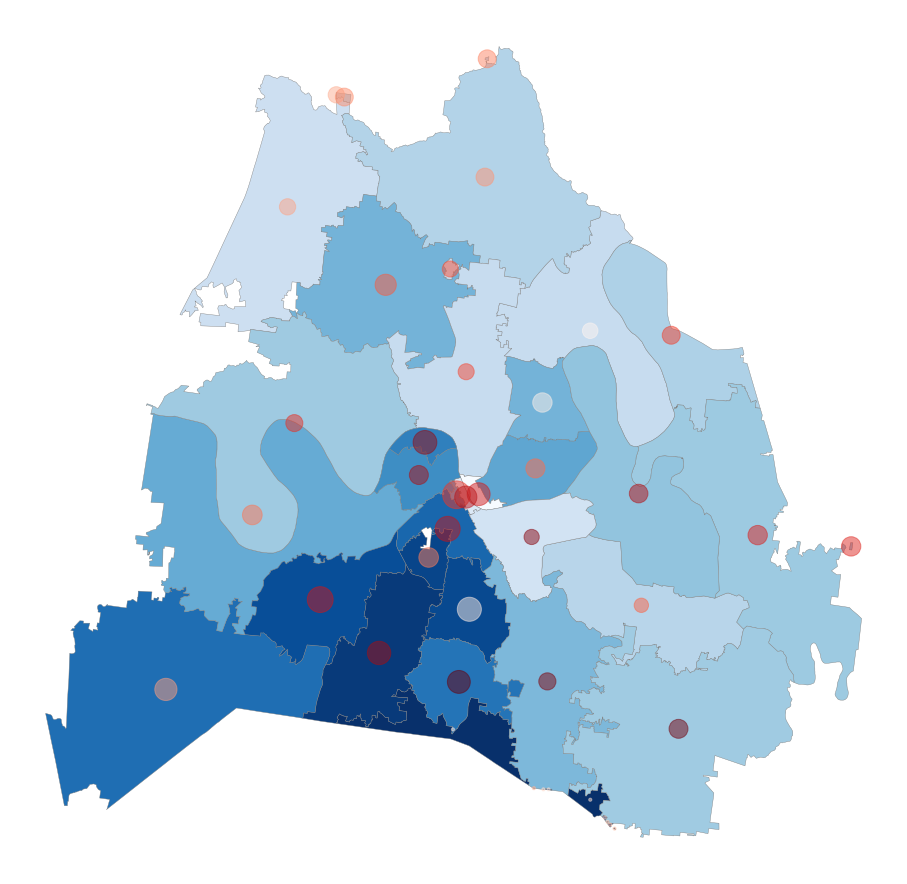

In [50]:
fig, ax = plt.subplots(figsize=(16,16))
test_map.plot(ax=ax, column="perc_master", cmap="Blues", edgecolor="grey", linewidth=0.4)
test_points.plot(ax=ax,cmap='Reds', markersize = "vacc_density", alpha=.5, categorical= False , legend=True)

ax.axis("off")
plt.axis('equal')
plt.show()

###
Possible Colors: 'BlBr' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [55]:
edu_map

,zip,objectid,po_name,shape_stlength,shape_starea,geometry,tot_cases,vacc_count,Population,Den,...,perc_12_orless,perc_hs_grad,perc_associate,perc_bachelor,perc_master,perc_professional,perc_doctorate,somecollege,highered,college_eded
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ...",4574,8520.0,35192,NaN,...,18.28,33.97,7.17,12.48,5.17,0.87,0.44,21.63,6.48,28.11
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ...",2011,7230.0,19132,2791.23,...,8.50,21.65,6.98,29.33,10.06,1.26,1.23,21.00,12.55,33.55
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ...",1786,6410.0,11024,1491.97,...,4.27,7.03,5.10,42.47,19.06,6.69,3.19,12.18,28.94,41.12
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ...",231,352.0,35747,NaN,...,1.78,7.49,4.62,44.07,21.07,5.83,3.93,11.20,30.83,42.03
4,37027,31,BRENTWOOD,3116.4327152718852,304596.06201171875,"MULTIPOLYGON (((-86.72012 36.00886, -86.72012 ...",231,352.0,35747,NaN,...,1.78,7.49,4.62,44.07,21.07,5.83,3.93,11.20,30.83,42.03
5,37027,30,BRENTWOOD,30401.649619169264,24460979.921020508,"MULTIPOLYGON (((-86.68705 36.01059, -86.68695 ...",231,352.0,35747,NaN,...,1.78,7.49,4.62,44.07,21.07,5.83,3.93,11.20,30.83,42.03
6,37027,29,BRENTWOOD,524.2364158788497,5803.0636596679687,"MULTIPOLYGON (((-86.72541 36.00934, -86.72540 ...",231,352.0,35747,NaN,...,1.78,7.49,4.62,44.07,21.07,5.83,3.93,11.20,30.83,42.03
7,37027,28,BRENTWOOD,3028.3872771754991,553384.08331298828,"MULTIPOLYGON (((-86.68475 35.99279, -86.68488 ...",231,352.0,35747,NaN,...,1.78,7.49,4.62,44.07,21.07,5.83,3.93,11.20,30.83,42.03
8,37027,27,BRENTWOOD,1678.1723515222479,156012.904296875,"MULTIPOLYGON (((-86.68367 35.99140, -86.68419 ...",231,352.0,35747,NaN,...,1.78,7.49,4.62,44.07,21.07,5.83,3.93,11.20,30.83,42.03
9,37027,44,BRENTWOOD,1315.615824819155,78289.863037109375,"MULTIPOLYGON (((-86.67793 35.98782, -86.67941 ...",231,352.0,35747,NaN,...,1.78,7.49,4.62,44.07,21.07,5.83,3.93,11.20,30.83,42.03


In [59]:
edu_map.sort_values(by=['college_eded'])

,zip,objectid,po_name,shape_stlength,shape_starea,geometry,tot_cases,vacc_count,Population,Den,...,perc_12_orless,perc_hs_grad,perc_associate,perc_bachelor,perc_master,perc_professional,perc_doctorate,somecollege,highered,college_eded
30,37213,4,NASHVILLE,30678.541831175633,23392261.943359375,"MULTIPOLYGON (((-86.77787 36.17706, -86.77810 ...",65,72.0,137,188.67,...,0.00,71.05,0.00,28.95,0.00,0.00,0.00,0.00,0.00,0.00
38,37210,12,NASHVILLE,93234.882954078275,265638803.54284668,"MULTIPOLYGON (((-86.70788 36.16764, -86.70778 ...",2100,3747.0,16170,1747.70,...,20.25,29.07,5.78,20.18,3.97,1.49,0.86,18.40,6.32,24.72
13,37080,32,JOELTON,258036.51004561348,868231536.13537598,"MULTIPOLYGON (((-86.90742 36.39053, -86.90725 ...",574,1970.0,7394,NaN,...,21.11,33.86,6.65,11.86,4.57,1.52,1.06,19.36,7.15,26.51
12,37080,42,JOELTON,2319.8074237329579,56522.611450195313,"MULTIPOLYGON (((-86.86263 36.37811, -86.86264 ...",574,1970.0,7394,NaN,...,21.11,33.86,6.65,11.86,4.57,1.52,1.06,19.36,7.15,26.51
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ...",4574,8520.0,35192,NaN,...,18.28,33.97,7.17,12.48,5.17,0.87,0.44,21.63,6.48,28.11
21,37217,56,NASHVILLE,179866.56847992647,517579208.08972168,"MULTIPOLYGON (((-86.67355 36.12729, -86.66687 ...",3907,5837.0,28293,1488.46,...,14.31,28.47,6.87,22.22,6.24,0.69,0.50,20.70,7.43,28.13
39,37211,39,NASHVILLE,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ...",10233,19175.0,64753,3030.86,...,17.82,22.83,5.64,24.78,9.59,1.56,1.23,16.55,12.38,28.93
23,37207,49,NASHVILLE,14456.130686344946,6987521.0933837891,"MULTIPOLYGON (((-86.78596 36.29097, -86.78595 ...",4729,9255.0,35744,1712.06,...,16.56,34.29,5.59,14.50,5.11,0.69,0.92,22.36,6.72,29.08
24,37207,48,NASHVILLE,196775.60104082408,556772811.32653809,"MULTIPOLYGON (((-86.75459 36.29021, -86.75465 ...",4729,9255.0,35744,1712.06,...,16.56,34.29,5.59,14.50,5.11,0.69,0.92,22.36,6.72,29.08
33,37201,14,NASHVILLE,25670.555742711778,11151362.94934082,"MULTIPOLYGON (((-86.77973 36.17460, -86.77823 ...",299,576.0,1167,3602.97,...,11.38,19.49,2.23,37.15,2.94,1.43,1.43,23.95,5.80,29.75
